# Policy-Gradients with the REINFORCE algorithm

**Overview**:
In this practical we will train an agent using the REINFORCE algorithm to learn to balance a pole in the OpenAI gym [Cartpole environment](https://gym.openai.com/envs/CartPole-v1).

**Learning objectives**:
* Understand the policy-gradient approach to directly training a parameterised policy to maximise expected future rewards.
* Understand how the policy-gradient theorem allows us to improve the policy using on-policy.

**What is expected of you**:
 * Go through the explanation, keeping the above learning objectives in mind.
 * Fill in the missing code ("#IMPLEMENT-ME") and train a model to solve the Cartpole-v1 environment in OpenAI gym (you solve it when reward=500).

# A Simple Policy-Gradient Cartpole Example

## Introduction

We have seen in your course that there are many different approaches to training RL agents. In this practical we will take a look at REINFORCE - a simple policy-based method. REINFORCE (and policy-based methods in general) directly optimise a parametrised policy in order to maximise future rewards.

We will try to learn a policy $\pi_\theta(a | s)$ which outputs a distribution over the possible actions $a$, given the current state $s$ of the environment. The goal is find a set of parameters $\theta$ to maximise the expected discounted return:
\begin{align}
J(\theta) = \mathbb{E}_{\tau \sim p_\theta} \left[\sum_{t=0}^T \gamma^t r(s_t, a_t)\right],
\end{align}
where $\tau$ is a trajectory sampled from $p_\theta$. The **policy-gradient** theorem gives us the derivative of this objective function:
\begin{align}
    \nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim p_\theta} \left[\left(\sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t)\right) \left(\sum_{t=0}^T \gamma^t r(s_t, a_t) \right) \right].
\end{align}

**NOTE**: 
* We have a policy $\pi_\theta(a|s)$ which tells the agent which action $a$ to take, given the state $s$, and it is parameterised in terms of parameters $\theta$.
* Our goal is to maximise $J(\theta)$ by **choosing actions from this policy** that lead to high future rewards.
* We'll use gradient-based optimisation to update the policy parameters $\theta$. We therefore want the gradient of our objective wrt the policy parameters.
* We use the policy-gradient theorem to find a expression for the gradient. This is an expectation over trajectories from our policy and the environment.
* Since we can now sample trajectories $(s_0, a_0, r_1, s_1, a_1, r_2, \ldots)$ using our policy $\pi_\theta$, we can approximate this gradient using **[Monte-Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_integration)** methods.

This algorithm is called **Monte-Carlo REINFORCE**, and is one type of policy-gradient algorithm. Let's use this to solve the Cartpole environment!

**Monte-Carlo REINFORCE**:

for each episode:
1. sample a trajectory $\tau$ using the policy $\pi_\theta$.
2. compute $\nabla_\theta J(\theta) \approx \left(\sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t)\right) \left(\sum_{t=0}^T \gamma^t r(s_t, a_t) \right)$.
3. update policy parameters $\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta)$


### Install Pytorch
Website: https://pytorch.org/

Command without cuda (only cpu)

    pip install torch==1.3.1+cpu torchvision==0.4.2+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [4]:
# import various packages
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [5]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

# configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

device: cpu


## The Environment - Cart Pole

Cartpole is a standard benchmark in reinforcement learning and is a good sandbox for trying things out. The goal is to balance a pendulum on top of a moving cart. We have 2 actions - either push the cart to the left or push to the right. The state space consists of the cart's position and velocity and the pendulum's angle and angular velocity. For more details refer to the OpenAi/gym github wiki page ([link](https://github.com/openai/gym/wiki/CartPole-v0)) 

Let's create the environment and take a look at the state and action spaces.

In [6]:
env = gym.make('CartPole-v1')
print('Environment:', 'CartPole-v1')
print('\t','action space:', env.action_space)
print('\t','observation space:', env.observation_space)

Environment: CartPole-v1
	 action space: Discrete(2)
	 observation space: Box(4,)


Here we can see that there are 2 discrete actions and a **continuous** state space.

**Observation**
Type: Box(4)

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -41.8&deg; | ~ 41.8&deg;
3 | Pole Velocity At Tip | -Inf | Inf

**Actions**
Type: Discrete(2)

Num | Action
--- | ---
0 | Push cart to the left
1 | Push cart to the right

### Taking a few steps

To get a better feel for the environment, we will use a random policy to genrate a short trajectory.

In [7]:
SUB = str.maketrans("t0123456789+", "ₜ₀₁₂₃₄₅₆₇₈₉₊")
print('-'*115)

state = env.reset()
for i in range (5):
    # sample random action
    action = env.action_space.sample()
    # take action in the environment
    new_state, reward, done, _ = env.step(action)
    
    print('Step t=', i+1, ': (', 'st, at , rt, st+1'.translate(SUB),')')
    print('(', state, ',', action, ',', reward, ',', new_state, ')')
    print('-'*115)
    
    state = new_state

-------------------------------------------------------------------------------------------------------------------
Step t= 1 : ( sₜ, aₜ , rₜ, sₜ₊₁ )
( [-0.04914724 -0.0347901  -0.04675309  0.01865991] , 0 , 1.0 , [-0.04984304 -0.22921146 -0.0463799   0.29623287] )
-------------------------------------------------------------------------------------------------------------------
Step t= 2 : ( sₜ, aₜ , rₜ, sₜ₊₁ )
( [-0.04984304 -0.22921146 -0.0463799   0.29623287] , 0 , 1.0 , [-0.05442727 -0.4236426  -0.04045524  0.57393515] )
-------------------------------------------------------------------------------------------------------------------
Step t= 3 : ( sₜ, aₜ , rₜ, sₜ₊₁ )
( [-0.05442727 -0.4236426  -0.04045524  0.57393515] , 1 , 1.0 , [-0.06290012 -0.22797751 -0.02897653  0.26878706] )
-------------------------------------------------------------------------------------------------------------------
Step t= 4 : ( sₜ, aₜ , rₜ, sₜ₊₁ )
( [-0.06290012 -0.22797751 -0.02897653  0.26878706] 

### Watching a random policy agent play

Let's also see how a random policy performs in this enviroment:

In [8]:
env_1 = gym.make('CartPole-v1')
state = env_1.reset()
for _ in range(200):
    # sample a random action
    action = env_1.action_space.sample()
    env_1.render()
    state, reward, done, _ = env_1.step(action)
env_1.close()
del env_1

/Users/shahil/miniconda3/envs/rl/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Not very good! The pole only stayed up for a few time steps... 

Now let's improve this using REINFORCE.

## The Policy

We begin by parameterising the policy $\pi_\theta(a | s)$ as a simple neural network which takes the state (a vector of 4 elements provided by `gym`) as input, and produces a Categorical distribution over the possible actions as output. Simple enough. Refer to [torch.nn](https://pytorch.org/docs/stable/nn.html)

In [9]:
class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        # Define neural network layers. Refer to nn.Linear (https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)
        # We are going to use a neural network with one hidden layer of size 16.
        # The first layer should have an input size of env.observation_space.shape and an output size of 16
        self.fc1 = nn.Linear(s_size, h_size)
        # The second layer should have an input size of 16 and an output size of env.action_space.n
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        # The forward pass
        # apply a ReLU activation after the first linear layer
        x = F.relu(self.fc1(x))
        # apply the second linear layer (without an activation).
        # the outputs of the second layer will act as the log probabilities for the Categorial distribution.
        x = self.fc2(x)
        return Categorical(logits=x)

### Selecting actions with our policy

For a given state our policy returns a pytorch `Categorial` object. We can sample from this distribution by calling it's `sample` method and we can find the log probability of an action using `log_prob`:

In [10]:
policy = Policy().to(device)
state = env.reset()
# convert state (a numpy array) to a torch tensor
state = torch.from_numpy(state).float().to(device)
dist = policy(state)
action = dist.sample()

print("Sampled action: ", action.item())
print("Log probability of action: ", dist.log_prob(action).item())

Sampled action:  0
Log probability of action:  -0.5579491257667542


### Computing the return

Given a sequence of rewards $(r(s_0, a_0), \ldots, r(s_T, a_T))$ we want to calculate the return $\sum_{t=0}^T \gamma^t r(s_t, a_t)$.

In [11]:
def compute_returns(rewards, gamma):
    # compute the return using the above equation
    returns = 0
    for step in range(len(rewards)):
        returns += gamma**step * rewards[step]
    return returns

## REINFORCE

Now its time to implement the algorithm

**Monte-Carlo REINFORCE**:

for each episode:
1. sample a trajectory $\tau$ using the policy $\pi_\theta$.
2. compute $\nabla_\theta J(\theta) \approx \left(\sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t)\right) \left(\sum_{t=0}^T \gamma^t r(s_t, a_t) \right)$.
3. update policy parameters $\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta)$

### Hyperameters

In [12]:
learning_rate = 1e-2
number_episodes = 1500
max_episode_length = 1000
gamma = 1.0

In [13]:
def reinforce(env, seed, verbose=True):
    # set random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    env.seed(seed)

    # instantiate the policy and optimizer
    policy = Policy().to(device)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    scores = []
    scores_deque = deque(maxlen=100)
    for episode in range(1, number_episodes+1):
        #################################################################
        # 1. Collect trajectories using our policy and save the rewards #
        # and the log probability of each action taken.                 #
        #################################################################
        log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_episode_length):
            # get the distribution over actions for state
            dist = policy(torch.from_numpy(state).float().to(device))

            # sample an action from the distribution
            action = dist.sample()

            # compute the log probability
            log_prob = dist.log_prob(action).unsqueeze(0)

            # take a step in the environment
            state, reward, done, _ = env.step(action.item())

            # save the reward and log probability
            rewards.append(reward)
            log_probs.append(log_prob)

            if done:
                break

        # for reporting save the score
        scores.append(sum(rewards))
        scores_deque.append(sum(rewards))

        #################################################################
        # 2. evaluate the policy gradient                               #
        #################################################################
        
        # calculate the discounted return of the trajectory
        returns = compute_returns(rewards, gamma)

        log_probs = torch.cat(log_probs)
        #  multiply the log probabilities by the returns and sum 
        # (remember to multiply the result by -1 because we want to maximise the returns)
        policy_loss = -torch.sum(log_probs*returns)

        #################################################################
        # 3. update the policy parameters (gradient descent)            #
        #################################################################
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # report the score to check that we're making progress
        if episode % 50 == 0 and verbose:
            print('Episode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)))

        if np.mean(scores_deque) >= 495.0 and verbose:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)))
            break
            
    return policy, scores

In [14]:
env = gym.make('CartPole-v1')
policy, scores = reinforce(env ,42)

Episode 50	Average Score: 27.78
Episode 100	Average Score: 32.39
Episode 150	Average Score: 42.82
Episode 200	Average Score: 46.35
Episode 250	Average Score: 51.75
Episode 300	Average Score: 58.77
Episode 350	Average Score: 67.28
Episode 400	Average Score: 78.60
Episode 450	Average Score: 79.20
Episode 500	Average Score: 82.28
Episode 550	Average Score: 101.07
Episode 600	Average Score: 111.77
Episode 650	Average Score: 115.17
Episode 700	Average Score: 253.49
Episode 750	Average Score: 371.92
Episode 800	Average Score: 324.80
Episode 850	Average Score: 233.88
Episode 900	Average Score: 103.90
Episode 950	Average Score: 95.75
Episode 1000	Average Score: 324.37
Episode 1050	Average Score: 489.01
Episode 1100	Average Score: 463.15
Episode 1150	Average Score: 468.13
Episode 1200	Average Score: 475.18
Episode 1250	Average Score: 475.18
Environment solved in 1270 episodes!	Average Score: 495.93


## Seeing our learned policy in action

Let's watch our learned policy balance the pole!

In [15]:
env_1 = gym.make('CartPole-v1')
state = env_1.reset()
for t in range(2000):
    dist = policy(torch.from_numpy(state).float().to(device))
    action = dist.sample()
    env_1.render()
    state, reward, done, _ = env_1.step(action.item())
    if done:
        break
env_1.close()
del env_1

### Plotting the results

Finally, let's plot the learning curve.

In [16]:
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

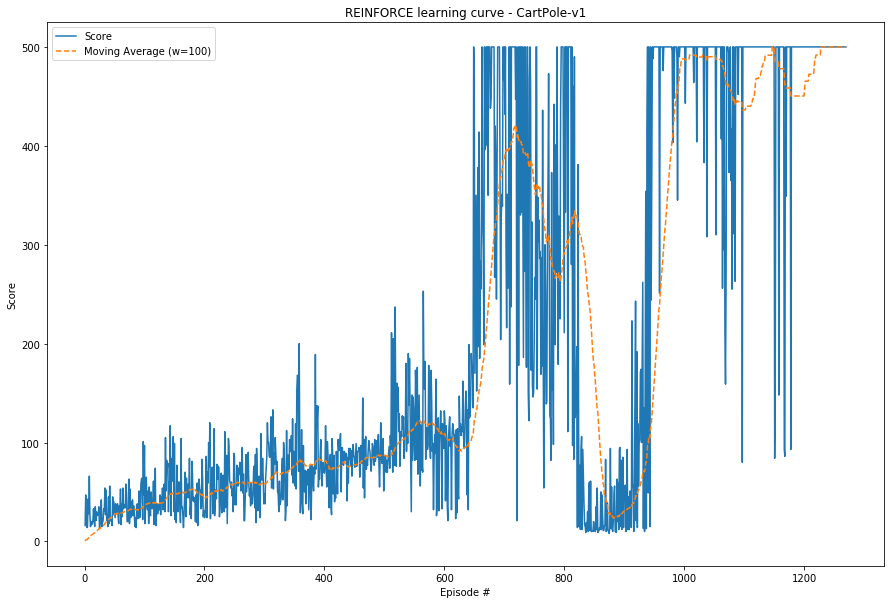

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores)+1)
ax.plot(x, scores, label='Score')
m_average = moving_average(scores, 50)
ax.plot(x, m_average, label='Moving Average (w=100)', linestyle='--')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('REINFORCE learning curve - CartPole-v1')
plt.show()

We can see that at the end of training our policy consistantly (more or less) recieves returns of 500.

## Investigating the variance of REINFORCE

We noted in class that REINFORCE is a high variance algorithm. We can investigate the variance by running multiple trials and averaging the results.

In [18]:
env = gym.make('CartPole-v1')
np.random.seed(53)
seeds = np.random.randint(1000, size=5)
all_scores = []
for seed in seeds:
    print("started training with seed: ", seed)
    _, scores = reinforce(env, int(seed), verbose=False)
    print("completed training with seed: ", seed)
    all_scores.append(scores)

started training with seed:  537
completed training with seed:  537
started training with seed:  797
completed training with seed:  797
started training with seed:  885
completed training with seed:  885
started training with seed:  421
completed training with seed:  421
started training with seed:  763
completed training with seed:  763


In [19]:
smoothed_scores = [moving_average(s, 50) for s in all_scores]
smoothed_scores = np.array(smoothed_scores)
mean = smoothed_scores.mean(axis=0)
std = smoothed_scores.std(axis=0)

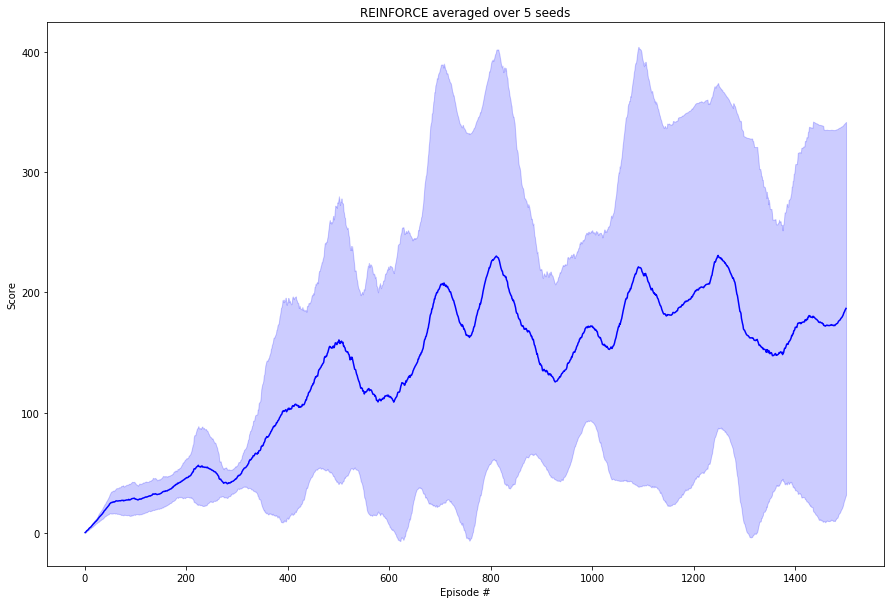

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(mean)+1)
ax.plot(x, mean, '-', color='blue')
ax.fill_between(x, mean - std, mean + std, color='blue', alpha=0.2)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('REINFORCE averaged over 5 seeds')
plt.show()

## Reducing the variance of REINFORCE 

In class we saw a couple of tricks to reduce the variance of REINFORCE and improve its performance. Firstly, future actions should not change past decision. Present actions only impact the future. Therefore, we can change our objective function to reflect this:
\begin{align}
    \nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim p_\theta} \left[\sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) \sum_{t'= t}^T \gamma^{t'- t} r(s_{t'}, a_{t'})\right].
\end{align}

We can also reduce variance by subtracing a state dependent baseline to get:
\begin{align}
    \nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim p_\theta} \left[\sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) \sum_{t'= t}^T \left( \gamma^{t'- t} r(s_{t'}, a_{t'}) - b(s_{t'}) \right)\right].
\end{align}

For our baseline we'll use the average of the returns over the trajectory. As a final trick we normalise the returns by dividing by the standard deviation. 

In [21]:
def compute_returns_baseline(rewards, gamma):
    r = 0
    returns = []
    for step in reversed(range(len(rewards))):
        r = rewards[step] + gamma * r
        returns.insert(0, r)
    returns = np.array(returns)
    returns -= returns.mean()
    returns /= returns.std()
    return returns

In [22]:
def reinforce_baseline(env, seed, verbose=True):
    # set random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    env.seed(seed)

    # instantiate the policy and optimizer
    policy = Policy().to(device)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    scores = []
    scores_deque = deque(maxlen=100)
    for episode in range(1, number_episodes+1):
        #################################################################
        # 1. Collect trajectories using our policy and save the rewards #
        # and the log probability of each action taken.                 #
        #################################################################
        log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_episode_length):
            # get the distribution over actions for state
            dist = policy(torch.from_numpy(state).float().to(device))

            # sample an action from the distribution
            action = dist.sample()

            # compute the log probability
            log_prob = dist.log_prob(action).unsqueeze(0)

            # take a step in the environment
            state, reward, done, _ = env.step(action.item())

            # save the reward and log probability
            rewards.append(reward)
            log_probs.append(log_prob)

            if done:
                break

        # for reporting save the score
        scores.append(sum(rewards))
        scores_deque.append(sum(rewards))

        #################################################################
        # 2. evaluate the policy gradient                               #
        #################################################################
        
        # calculate the discounted return of the trajectory
        returns = compute_returns_baseline(rewards, gamma)
        returns = torch.from_numpy(returns).float().to(device)

        log_probs = torch.cat(log_probs)
        #  multiply the log probabilities by the returns and sum 
        # (remember to multiply the result by -1 because we want to maximise the returns)
        policy_loss = -torch.sum(log_probs*returns)

        #################################################################
        # 3. update the policy parameters (gradient descent)            #
        #################################################################
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # report the score to check that we're making progress
        if episode % 50 == 0 and verbose:
            print('Episode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)))

        if np.mean(scores_deque) >= 495.0 and verbose:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)))
            break
            
    return policy, scores

Let's see if these changes give us any improvement.

In [23]:
env = gym.make('CartPole-v1')
np.random.seed(53)
seeds = np.random.randint(1000, size=5)
all_scores_baseline = []
for seed in seeds:
    print("started training with seed: ", seed)
    _, scores = reinforce_baseline(env ,int(seed), verbose=False)
    print("completed training with seed: ", seed)
    all_scores_baseline.append(scores)

started training with seed:  537
completed training with seed:  537
started training with seed:  797
completed training with seed:  797
started training with seed:  885
completed training with seed:  885
started training with seed:  421
completed training with seed:  421
started training with seed:  763
completed training with seed:  763


## Comparing the methods

Finally we'll compare the performance of the two methods.

In [24]:
smoothed_scores_baseline = [moving_average(s, 50) for s in all_scores_baseline]
smoothed_scores_baseline = np.array(smoothed_scores_baseline)
mean_baseline = smoothed_scores_baseline.mean(axis=0)
std_baseline = smoothed_scores_baseline.std(axis=0)

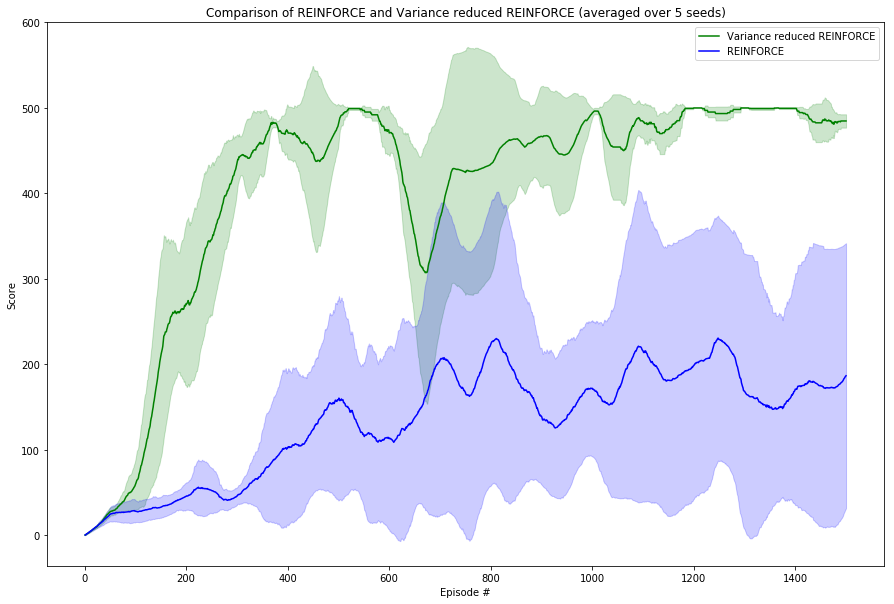

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(mean_baseline)+1)
ax.plot(x, mean_baseline, '-', color='green', label='Variance reduced REINFORCE')
ax.plot(x, mean, '-', color='blue', label='REINFORCE')
ax.fill_between(x, mean_baseline - std_baseline, mean_baseline + std_baseline, color='green', alpha=0.2)
ax.fill_between(x, mean - std, mean + std, color='blue', alpha=0.2)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.title('Comparison of REINFORCE and Variance reduced REINFORCE (averaged over 5 seeds)')
plt.show()